# Trotterized time evolution in the (1,2,1) Hamiltonian

Begin with an implementation of a Trotterization of the time evolution operator $U(t',t)$ that is not yet decomposed into 'gates'.

### Schrodinger picture

In Schrodinger picture, the time evolution operator is simply $\exp(-i H t)$. This is first Trotterized in time to become

$$ \exp(-i H t) = \bigg[ \exp(-i H_E t / N) \exp(-i H_B t / N) \bigg]^N + \mathcal{O}(t^2/N^2)$$

In [1]:
import numpy as np
import scipy as sp
import large_N_module as ln
from scipy import sparse
import matplotlib.pyplot as plt

## Direct exponentiation

In [9]:
def U_expm(H, t):
    """
    Compute the matrix exponential of H*t using scipy's expm function.
    """
    return sparse.linalg.expm(-1j * H * t)

In [10]:
g = 0.7
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3

# Define the Hamiltonian
H = ln.make_ham(g, lat_shape, boundary, N_colors)

# Get the ground state
ground_state = ln.get_ground_state(g, lat_shape, boundary, N_colors)

def measure_single_qubit(psi, p, lat_shape, outcome=0):
    """
    Measure the state psi at position p in the lattice, and get the outcome as the result of the measurement.
    outcome = 0 or 1
    """
    L, H = lat_shape
    n = L * H
    if outcome == 0:
        psi_p = ln.one_qubit_gate(ln.P0, p, n) @ psi
        return ( psi_p ) / np.linalg.norm( psi_p )
    elif outcome == 1:
        psi_p = ln.one_qubit_gate(ln.P1, p, n) @ psi
        return ( psi_p ) / np.linalg.norm( psi_p )
    else:
        raise ValueError("Outcome must be either 0 or 1.")
    
    
def prob_0_single_qubit(psi, p, lat_shape):
    """
    Measure the probability of getting outcome 0 when measuring the state psi at position p in the lattice.
    """
    psi = psi / np.linalg.norm(psi)
    return np.abs( np.vdot(psi, measure_single_qubit(psi, p, lat_shape, outcome=0)) )**2


def prob_0_all_qubits(psi, lat_shape):
    """
    Measure the probability of getting outcome 0 when measuring the state psi at all positions in the lattice.
    """
    L, H = lat_shape
    prob_0_arr = np.zeros(lat_shape)
    for i in range(L):
        for j in range(H):
            p = ln.map_to_circuit(i, j, lat_shape)
            prob_0_arr[i, j] = prob_0_single_qubit(psi, p, lat_shape)
    return prob_0_arr

ground_state_p = measure_single_qubit(ground_state, 4, lat_shape, outcome=0)


prob_0_p = np.vdot(ground_state_p, ground_state)**2



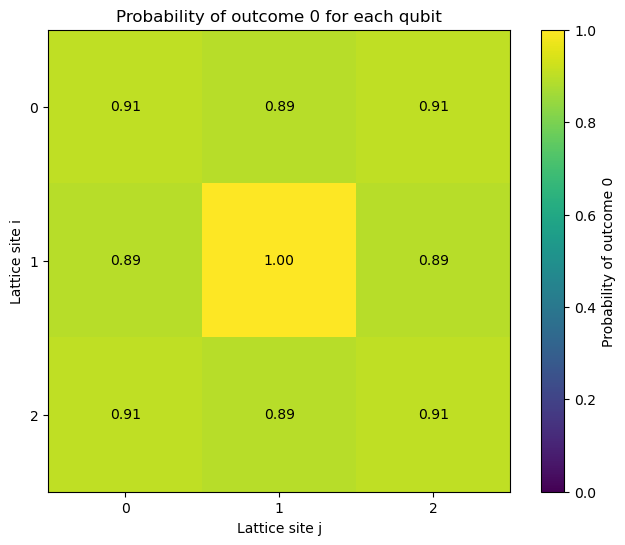

In [148]:
prob_0_arr = prob_0_all_qubits(ground_state_p, lat_shape)

# plot a heat map of the probabilities, with the color bar ranging from 0 to 1
# write the value of the probability at each point in the lattice
plt.figure(figsize=(8, 6))
plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Probability of outcome 0')
plt.title('Probability of outcome 0 for each qubit')
plt.xlabel('Lattice site j')
plt.ylabel('Lattice site i')
plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

for i in range(lat_shape[0]):
    for j in range(lat_shape[1]):
        p = ln.map_to_circuit(i, j, lat_shape)
        plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()



In [76]:
# time evolve the measured state, and plot the probability of getting outcome 0 at each time step
T = 3
dt = 0.03
tvals = np.arange(0, T, dt)

U_dt = U_expm(H, dt)
psi_t = np.zeros((len(tvals), 2**(lat_shape[0]*lat_shape[1])), dtype=complex)
psi_t[0] = ground_state_p
for i in range(1, len(tvals)):
    psi_t[i] = U_dt @ psi_t[i-1]
    #psi_t[i] /= np.linalg.norm(psi_t[i]) # Normalize the state at each time step



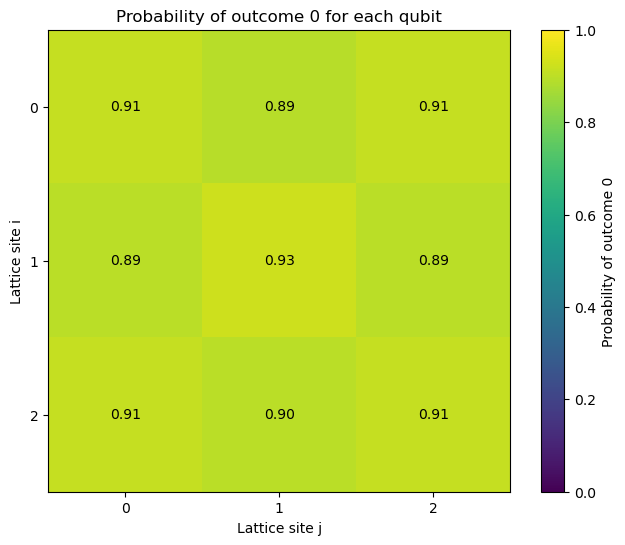

In [149]:
prob_0_arr = prob_0_all_qubits(psi_t[80], lat_shape)

# plot a heat map of the probabilities, with the color bar ranging from 0 to 1
# write the value of the probability at each point in the lattice
plt.figure(figsize=(8, 6))
plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Probability of outcome 0')
plt.title('Probability of outcome 0 for each qubit')
plt.xlabel('Lattice site j')
plt.ylabel('Lattice site i')
plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

for i in range(lat_shape[0]):
    for j in range(lat_shape[1]):
        p = ln.map_to_circuit(i, j, lat_shape)
        plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

In [ ]:

for i, t in enumerate(tvals):
    prob_0_arr = prob_0_all_qubits(psi_t[i], lat_shape)
    # plot a heat map of the probabilities, with the color bar ranging from 0 to 1
    # write the value of the probability at each point in the lattice
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar(label='Probability of outcome 0')
    plt.title(f'Probability of outcome 0 for each qubit at t={t:.2f}')
    plt.xlabel('Lattice site j')
    plt.ylabel('Lattice site i')
    plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
    plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

    for i in range(lat_shape[0]):
        for j in range(lat_shape[1]):
            p = ln.map_to_circuit(i, j, lat_shape)
            plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
    plt.savefig(f'prob_0_arr_t_{t:.2f}.jpg', dpi=300)
    plt.close()


### Check convergence rate of time-trotterized U with step size dt

In [4]:
# pick some parameters
g = 0.8
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3

# Create the Hamiltonian
H_E = ln.make_electric_ham(g, lat_shape, boundary, N_colors)
H_B = ln.make_magnetic_ham(g, lat_shape, boundary, N_colors)
H = H_E + H_B

# Pick some time values
T = 3
dt = 0.03
tvals = np.arange(0, T, dt)

# Create the time evolution operator for the total time
U_T = U_expm(H, T)

# Create the time evolution operator for each time step
U_E_dt = U_expm(H_E, dt)
U_B_dt = U_expm(H_B, dt)
U_dt = U_E_dt @ U_B_dt

U_trot = sp.sparse.eye(2**(lat_shape[0]*lat_shape[1]), dtype=complex)
for i in range(len(tvals)):
    U_trot = U_dt @ U_trot

In [5]:
# Compare the two time evolution operators
U_diff = U_T - U_trot
# Compute the norm of the difference
norm_U_diff = sp.linalg.norm(U_diff.toarray())
print(f'Norm of the difference between U_T and U_trot: {norm_U_diff:.2e}')

Norm of the difference between U_T and U_trot: 2.93e-01


In [7]:
# Repeat the above process for a variety of step sizes dt

# Create a list of number of steps
n_steps = [3, 5, 10, 20, 50, 100, 200, 500]
# Create a list of time step sizes
dt_list = [T/n for n in n_steps]

# Create a list to store the norms of the differences
norm_U_diff_list = []

# Loop over the step sizes
for dt in dt_list:
    # Create the time evolution operator for each time step
    U_E_dt = U_expm(H_E, dt)
    U_B_dt = U_expm(H_B, dt)
    U_dt = U_E_dt @ U_B_dt
    U_trot = sp.sparse.eye(2**(lat_shape[0]*lat_shape[1]), dtype=complex)
    tvals = np.arange(0, T, dt)
    for i in range(len(tvals)):
        U_trot = U_dt @ U_trot

    # Compare the two time evolution operators
    U_diff = U_T - U_trot
    # Compute the norm of the difference
    norm_U_diff = sp.linalg.norm(U_diff.toarray())
    norm_U_diff_list.append(norm_U_diff)

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


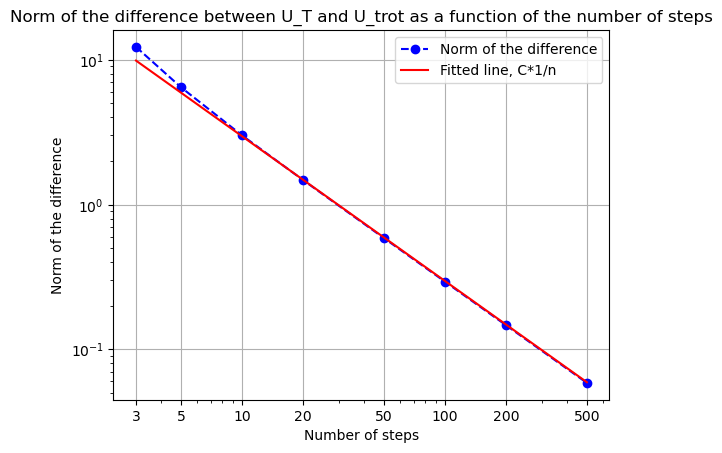

In [8]:
# Fit a polynomial to the data
coeffs = np.polyfit(np.log(n_steps), np.log(norm_U_diff_list), 1)
#Create a polynomial function from the coefficients
poly = np.poly1d([-1, coeffs[1]-0.15])
#Create a list of the fitted values
fitted_values = poly(np.log(n_steps))

# plot the norm of the difference as a function of the number of steps
plt.plot(n_steps, norm_U_diff_list, marker='o', linestyle='--', color='blue', label='Norm of the difference')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of steps')
plt.ylabel('Norm of the difference')
plt.title('Norm of the difference between U_T and U_trot as a function of the number of steps')
plt.grid()
plt.xticks(n_steps, n_steps)

# plot the fitted line
plt.plot(n_steps, np.exp(fitted_values), color='red', label='Fitted line, C*1/n')
plt.legend()


# set the scale of the axes of the plot to be equal
#plt.gca().set_aspect('equal', adjustable='box')

In [490]:
# Repeat the above process for a variety of step sizes dt

# Create a list of number of steps
n_steps = [3, 5, 10, 20, 50, 100, 200]
# Create a list of time step sizes
dt_list = [T/n for n in n_steps]

# Create a list to store the eigevnvalues of the approximate Hamiltonian for each step size
eigenvalues_list = []

# Loop over the step sizes
for dt in dt_list:
    # Create the time evolution operator for each time step
    U_E_dt = U_expm(H_E, dt)
    U_B_dt = U_expm(H_B, dt)
    U_dt = U_E_dt @ U_B_dt
    U_trot = sp.sparse.eye(2**(lat_shape[0]*lat_shape[1]), dtype=complex)
    tvals = np.arange(0, T, dt)
    for i in range(len(tvals)):
        U_trot = U_dt @ U_trot

    # Compute the approximate Hamiltonian
    H_trot = 1j * sp.linalg.logm(U_trot.toarray()) / T

    # Compute the eigenvalues of the approximate Hamiltonian
    eigenvalues, _ = np.linalg.eigh(H_trot )
    # Pick out the 7 smallest eigenvalues
    eigenvalues = np.sort(eigenvalues)[:7]
    eigenvalues_list.append(eigenvalues)

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
print( ln.get_ground_state_energy(g, lat_shape, boundary, N_colors) )

-3.3077379652627537


array([-0.98786879, -0.97532949, -0.97532949, -0.97532949, -0.97532949,
       -0.96877511, -0.96877511])

## Local trotterization

In addition to Trotterizing in time, we break up the exponential from a sum over sites, to a product of exponentials over sites.

Begin by breaking up the Hamiltonian's different terms:

$$ \exp\big( i t ( H_{E1} + H_{E2} + H_{B1} + H_{B2}) \big) \rightarrow \exp\big( i t ( H_{E1} + H_{E2} ) \big) \exp\big( i t (H_{B1} + H_{B2})  \big) + \mathcal{O}(t^2) $$

The electric and magnetic parts of the Hamiltonian do not commute, so we pick up an error proportional to their commutator.

For the electric part, the one and two-qubit operators all commute with each other, so with no error incurred we can write:

$$ \exp\bigg( i t ( \sum_p H_{E1,p} + H_{E2,p} ) \bigg) = \bigg[ \prod_p \exp(i t H_{E1, p}) \bigg] \bigg[ \prod_p \exp(i t H_{E2, p})\bigg]  $$

For the magnetic part, in general many of the 5-qubit operators do not commute with each other, but we can still break them up

$$ \exp\big( i t ( \sum_p H_{B1,p} + H_{B2,p}) \big) \rightarrow \bigg[ \prod_p \exp(i t H_{B1, p}) \bigg] \bigg[ \prod_p \exp(i t H_{B2, p})\bigg] + \mathcal{O}(t^2/g^4) $$

while incurring error of the same order as previously incurred when breaking up the magnetic and electric parts. Then the simplest way of breaking up the exponential is:

$$ \exp(- i H t) =  \bigg[ \prod_p \exp(- i t H_{E1, p}) \bigg] \bigg[ \prod_p \exp(- i t H_{E2, p})\bigg]\bigg[ \prod_p \exp(- i t H_{B1, p}) \bigg] \bigg[ \prod_p \exp(- i t H_{B2, p})\bigg] + \mathcal{O}(t^2) $$



In [70]:
def HE1_make_U_trotterized(g, lat_shape, t, N_colors=3):
    L, H = lat_shape
    n = L * H
    C = g*g*(N_colors - 1/N_colors)

    result = sparse.eye(1, format='csc') # create a sparse 1x1 matrix to store result
    HE1_op = sparse.linalg.expm( -1j * C * ln.P1 * t)

    for i in range(n):
        result = sp.sparse.kron(result, HE1_op, format='csc')
    
    return result


def HE2_make_U_trotterized(g, lat_shape, t, boundary = "periodic", N_colors=3):
    L, H = lat_shape
    n = L * H
    HE2_coeff = -0.5 * (N_colors - 1/N_colors)*g*g

    U = sparse.eye(2**n, format="csc")
    for p in range(n):
        _, _, nr, nu = ln.get_neighbours(p, lat_shape, boundary)

        P = ln.multi_qubit_gate({p: ln.P1, nu: ln.P1}, n)
        op = np.exp(-1j * t * HE2_coeff) * P + ( sparse.eye(2**n, format="csc") - P )
        
        U = op @ U

        P = ln.multi_qubit_gate({p: ln.P1, nr: ln.P1}, n)
        op = np.exp(-1j * t * HE2_coeff) * P + ( sparse.eye(2**n, format="csc") - P )
        
        U = op @ U
    
    return U
    

# Create a function to make the trotterized time evolution for the first magnetic term

def HB1_make_U_trotterized(g, lat_shape, t, boundary = "periodic"):
    L, H = lat_shape
    n = L * H
    HB1_coeff = - 1 / ( np.sqrt(2) * g * g)

    # Create the 2x2 sparse rotation matrix needed for the magnetic term
    RX = sparse.linalg.expm(-1j * HB1_coeff * t * ln.Xop)

    U = sparse.eye(2**n, format="csc") # For storing the result

    # loop over the lattice sites
    for p in range(n):
        # Get the neighbours of the current site
        nl, nd, nr, nu = ln.get_neighbours(p, lat_shape, boundary)
        # Create the multi-qubit projection operator for the neighbors
        P = ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
        # Efficiently compute the 5-qubit operator
        op = sparse.eye(2**n, format="csc") - P + ln.one_qubit_gate(RX, p, n) @ P

        U = op @ U

    return U

# Create a function to make the trotterized time evolution for the second magnetic term

def HB2_make_U_trotterized(g, lat_shape, t, boundary = "periodic", N_colors=3):
    L, H = lat_shape
    n = L * H
    HB2_coeff = - 1 / ( 2 * g * g * N_colors)

    # Create the 2x2 sparse rotation matrix needed for the magnetic term
    RX = sparse.linalg.expm(-1j * HB2_coeff * t * ln.Xop)

    U = sparse.eye(2**n, format="csc") # For storing the result

    # loop over the lattice sites
    for p in range(n):
        # Get the neighbours of the current site
        nl, nd, nr, nu = ln.get_neighbours(p, lat_shape, boundary)

        # Create the multi-qubit projection operator for the neighbors
        P =  ln.multi_qubit_gate({nl: ln.P1, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
        P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P1, nr: ln.P0, nu: ln.P0}, n)
        P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P1, nu: ln.P0}, n)
        P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P1}, n)
        # Efficiently compute the 5-qubit operator
        op = sparse.eye(2**n, format="csc") - P + ln.one_qubit_gate(RX, p, n) @ P

        U = op @ U

    return U

def make_U_trotterized(g, lat_shape, t, boundary='periodic', N_colors=3):
    """
    Create the trotterized time evolution operator for the Hamiltonian H = HE + HB.
    """
    U_E1 = HE1_make_U_trotterized(g, lat_shape, t, N_colors)
    U_E2 = HE2_make_U_trotterized(g, lat_shape, t, boundary, N_colors)
    U_B1 = HB1_make_U_trotterized(g, lat_shape, t, boundary)
    U_B2 = HB2_make_U_trotterized(g, lat_shape, t, boundary, N_colors)
    
    return U_E1 @ U_E2 @ U_B1 @ U_B2

In [26]:
# Test the HE1_make_U_trotterized function against the U_expm function
g = 0.6
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
t = 10

U_trotterized = HE1_make_U_trotterized(g, lat_shape, t, N_colors)
HE1 = (N_colors - 1/N_colors)*g*g * ln.sigma("P1", lat_shape, boundary)
U_expm_result = U_expm(HE1, t)

# Compare the two results
norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
print(f'Norm of the difference between U_trotterized and U_expm: {norm_diff:.2e}')

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Norm of the difference between U_trotterized and U_expm: 2.05e-13


In [36]:
# Test the HE2_make_U_trotterized function against the U_expm function
g = 1.1
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
t = 20

U_trotterized = HE2_make_U_trotterized(g, lat_shape, t, boundary, N_colors)
HE2 = -0.5*(N_colors - 1/N_colors)*g*g * ln.sigma("P1P1", lat_shape, boundary)
U_expm_result = U_expm(HE2, t)

# Compare the two results
norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
print(f'Norm of the difference between U_trotterized and U_expm: {norm_diff:.2e}')

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Norm of the difference between U_trotterized and U_expm: 1.63e-13


In [ ]:
# Create a function to make the trotterized time evolution for the first magnetic term

def HB1_make_U_trotterized(g, lat_shape, t, boundary = "periodic"):
    L, H = lat_shape
    n = L * H
    HB1_coeff = - 1 / ( np.sqrt(2) * g * g)

    # Create the 2x2 sparse rotation matrix needed for the magnetic term
    RX = sparse.linalg.expm(-1j * HB1_coeff * t * ln.Xop)

    U = sparse.eye(2**n, format="csc") # For storing the result

    # loop over the lattice sites
    for p in range(n):
        # Get the neighbours of the current site
        nl, nd, nr, nu = ln.get_neighbours(p, lat_shape, boundary)
        # Create the multi-qubit projection operator for the neighbors
        P = ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
        # Efficiently compute the 5-qubit operator
        op = sparse.eye(2**n, format="csc") - P + ln.one_qubit_gate(RX, p, n) @ P

        U = op @ U

    return U

In [57]:
# Test the HB1_make_U_trotterized function against the U_expm function
g = 1.1
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
t = 0.001

U_trotterized = HB1_make_U_trotterized(g, lat_shape, t, boundary)
HB1 = - 1/ (np.sqrt(2) * g * g) * ln.sigma("P0P0P0P0X", lat_shape, boundary)
U_expm_result = U_expm(HB1, t)

# Compare the two results
norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
print(f'Norm of the difference between U_trotterized and U_expm: {norm_diff:.2e}')

Norm of the difference between U_trotterized and U_expm: 2.05e-06


In [67]:
# Test the HE2_make_U_trotterized function against the U_expm function
g = 0.7
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
t = 0.1

U_trotterized = HB2_make_U_trotterized(g, lat_shape, t, boundary, N_colors)
HB2 = -1/(2*g*g*N_colors) * ln.sigma("P0P0P0P1X", lat_shape, boundary)
U_expm_result = U_expm(HB2, t)

# Compare the two results
norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
print(f'Norm of the difference between U_trotterized and U_expm: {norm_diff:.2e}')

Norm of the difference between U_trotterized and U_expm: 2.19e-02


In [ ]:
''' 
# The following code is commented out because it is not used in the current implementation.
'''

# def make_U_trotterized(t, lat_shape):
#     L, H = lat_shape
#     n = L*H

#     # Compute the trotterized E1 operator
#     U = sparse.eye(2**n, format="csc")
#     for p in range(n):
#         C = (N_colors - 1/N_colors)*g*g
#         op = ln.one_qubit_gate( sparse.linalg.expm(-1j * t * C * ln.P1), p, n )
#         U = op @ U

#      # Compute the trotterized E2 operator
#     for p in range(n):
#         _, _, nr, nu = ln.get_neighbours(p, lat_shape, boundary)
#         HE2_coeff = -0.5 * (N_colors - 1/N_colors)*g*g

#         P = ln.multi_qubit_gate({p: ln.P1, nu: ln.P1}, n)
#         op = np.exp(-1j * t * HE2_coeff) * P + ( sparse.eye(2**n, format="csc") - P )
        
#         U = op @ U

#         P = ln.multi_qubit_gate({p: ln.P1, nr: ln.P1}, n)
#         op = np.exp(-1j * t * HE2_coeff) * P + ( sparse.eye(2**n, format="csc") - P )
        
#         U = op @ U
    
#     # Compute the trotterized B1 operator
#     for p in range(n):
#         nl, nd, nr, nu = ln.get_neighbours(p, lat_shape, boundary)
#         P = ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
#         HB1_coeff = -np.sqrt(2)/(2*g*g)
#         RX = np.cos(- t * HB1_coeff)*ln.Id + 1j*np.sin(- t * HB1_coeff)*ln.Xop
#         op = ln.one_qubit_gate( RX, p, n )@P + ( sparse.eye(2**n, format='csc') - P )
#         U = op @ U

#     # Compute the trotterized B2 operator
#     for p in range(n):
#         nl, nd, nr, nu = ln.get_neighbours(p, lat_shape, boundary)
#         P = sparse.eye(2**n, format='csc')
#         P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
#         P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
#         P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)
#         P += ln.multi_qubit_gate({nl: ln.P0, nd: ln.P0, nr: ln.P0, nu: ln.P0}, n)

#         HB2_coeff = -1/(2*g*g*N_colors)
#         RX = np.cos(- t * HB2_coeff)*ln.Id + 1j*np.sin(- t * HB2_coeff)*ln.Xop

#         op = ln.one_qubit_gate( RX, p, n ) @ P + ( sparse.eye(2**n, format='csc') - P )

#         U = op @ U

#     return U

In [78]:
# Test tne make_U_trotterized function against the U_expm function

g = 1
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
t = 0.01

U_trotterized = make_U_trotterized(g, lat_shape, t, boundary, N_colors)
H = ln.make_ham(g, lat_shape, boundary, N_colors)
U_expm_result = U_expm(H, t)

# Compare the two results
norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
print(f'Norm of the difference between U_trotterized and U_expm: {norm_diff:.2e}')

Norm of the difference between U_trotterized and U_expm: 1.68e-03


In [124]:
# Check the difference between the two time evolution operators as a function of the time step size

g = 1
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3

tvals = np.array([0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])
norm_diff_list = []

for t in tvals:
    U_trotterized = make_U_trotterized(g, lat_shape, t, boundary, N_colors)
    H = ln.make_ham(g, lat_shape, boundary, N_colors)
    U_expm_result = U_expm(H, t)

    # Compare the two results
    norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
    norm_diff_list.append(norm_diff)

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


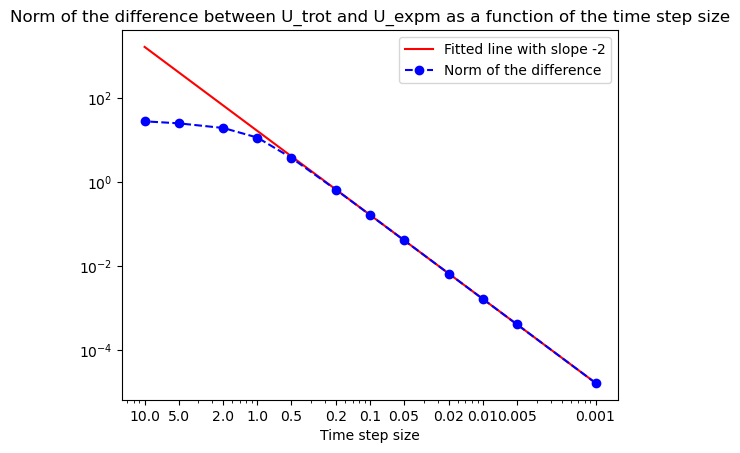

In [ ]:
# Fit a line to the log-log data
coeffs = np.polyfit(np.log(1/tvals), np.log(norm_diff_list), 1)

# plot the fitted line
fitted_values = [ np.exp(coeffs[1]+1.4) * (1/t)**(-2) for t in tvals ]

# plot the fitted line
plt.plot(1/tvals, fitted_values, color='red', label='Fitted line with slope -2')
plt.plot( 1/tvals, norm_diff_list, marker='o', linestyle='--', color='blue', label='Norm of the difference')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time step size')
plt.title('Norm of the difference (L2 norm) between U_trot and U_expm as a function of the time step size')
plt.xticks(1/tvals, tvals)
plt.legend()

In [132]:
# Compare the runtimes of the trotterization and expm time evolution operators for a range of lattice shapes

import time

g = 1
boundary = 'periodic'
N_colors = 3

lat_shapes = [(2, 2), (3, 3), (3, 4), (3, 5)]

# store the runtimes
runtimes_trotterized = []
runtimes_expm = []

T = 0.1

# compare the runtimes of the trotterization and expm time evolution operators for each lattice shape
for lat_shape in lat_shapes:
    start = time.time()
    U_trotterized = make_U_trotterized(g, lat_shape, T, boundary, N_colors)
    end = time.time()
    print(f'Time taken for trotterization for lattice shape {lat_shape}: {end - start:.4f} seconds')
    runtimes_trotterized.append(end - start)

    start = time.time()
    H = ln.make_ham(g, lat_shape, boundary, N_colors)
    U_expm_result = U_expm(H, T)
    end = time.time()
    print(f'Time taken for expm for lattice shape {lat_shape}: {end - start:.4f} seconds')
    runtimes_expm.append(end - start)

Time taken for trotterization for lattice shape (2, 2): 0.1078 seconds
Time taken for expm for lattice shape (2, 2): 0.0683 seconds
Time taken for trotterization for lattice shape (3, 3): 0.3541 seconds
Time taken for expm for lattice shape (3, 3): 0.7722 seconds
Time taken for trotterization for lattice shape (3, 4): 0.6333 seconds
Time taken for expm for lattice shape (3, 4): 30.6339 seconds
Time taken for trotterization for lattice shape (3, 5): 1.3966 seconds


KeyboardInterrupt: 

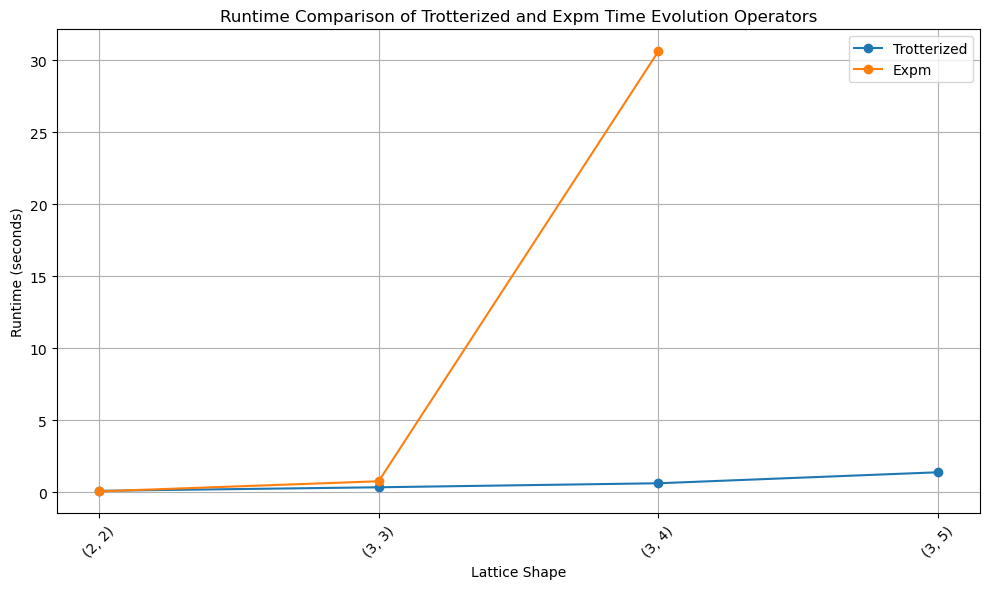

In [138]:
# plot the runtimes
plt.figure(figsize=(10, 6))
plt.plot([str(shape) for shape in lat_shapes], runtimes_trotterized, marker='o', label='Trotterized')
plt.plot([str(shape) for shape in lat_shapes[:-1]], runtimes_expm, marker='o', label='Expm')
plt.xlabel('Lattice Shape')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of Trotterized and Expm Time Evolution Operators')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [139]:
# Check the difference between the two time evolution operators as a function of the coupling

lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3
T = 0.05

g_vals = np.linspace(0.1, 2, 20)
norm_diff_list = []

for g in g_vals:
    U_trotterized = make_U_trotterized(g, lat_shape, T, boundary, N_colors)
    H = ln.make_ham(g, lat_shape, boundary, N_colors)
    U_expm_result = U_expm(H, T)
    
    # Compare the two results
    norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray())
    norm_diff_list.append(norm_diff)


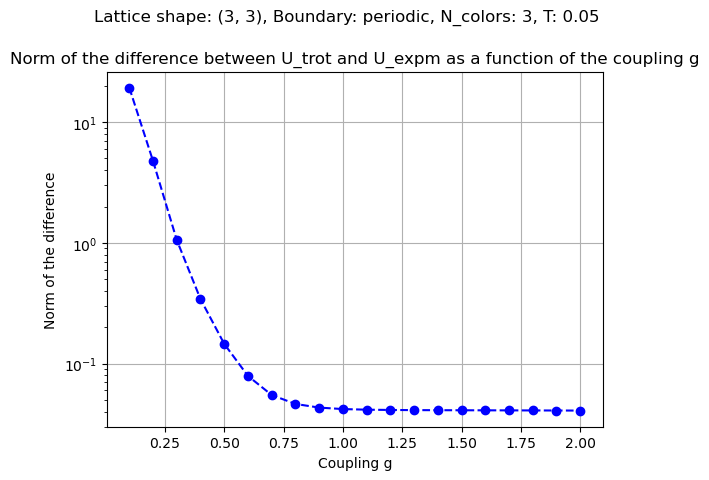

In [148]:
# plot the norm of the difference as a function of the coupling
plt.plot(g_vals, norm_diff_list, marker='o', linestyle='--', color='blue')
plt.xlabel('Coupling g')
plt.ylabel('Norm of the difference')
plt.title('Norm of the difference between U_trot and U_expm as a function of the coupling g')
# add a subtitle with the parameters used, and a smaller font size
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Lattice shape: {lat_shape}, Boundary: {boundary}, N_colors: {N_colors}, T: {T}')
plt.xscale('linear')
#plt.xscale('log')
plt.yscale('log')
#plt.xticks(g_vals, [f'{g:.1f}' for g in g_vals])
plt.grid()
plt.show()

In [149]:
# Check the difference between the two time evolution operators as a function of the time step size, using the L1 norm

g = 1
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3

tvals = np.array([0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])
norm_diff_list = []

for t in tvals:
    U_trotterized = make_U_trotterized(g, lat_shape, t, boundary, N_colors)
    H = ln.make_ham(g, lat_shape, boundary, N_colors)
    U_expm_result = U_expm(H, t)

    # Compare the two results
    norm_diff = sp.linalg.norm(U_trotterized.toarray() - U_expm_result.toarray(), ord=1)  # Using the L1 norm
    norm_diff_list.append(norm_diff)

/Users/iriandandrea/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


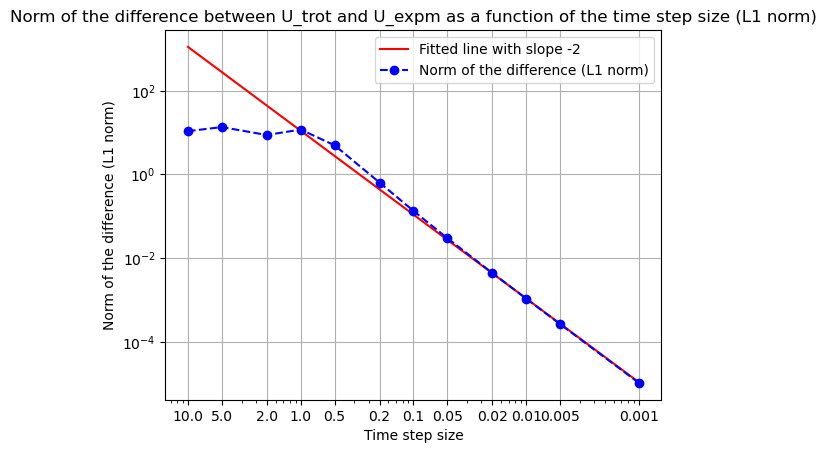

In [151]:
# Fit a line to the log-log data
coeffs = np.polyfit(np.log(1/tvals), np.log(norm_diff_list), 1)

# plot the fitted line
fitted_values = [ np.exp(coeffs[1]+1.4) * (1/t)**(-2) for t in tvals ]



# plot the norms of the differences
plt.plot(1/tvals, fitted_values, color='red', label='Fitted line with slope -2')
plt.plot(1/tvals, norm_diff_list, marker='o', linestyle='--', color='blue', label='Norm of the difference (L1 norm)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time step size')
plt.ylabel('Norm of the difference (L1 norm)')
plt.title('Norm of the difference between U_trot and U_expm as a function of the time step size (L1 norm)')
plt.xticks(1/tvals, tvals)
plt.legend()
plt.grid()
plt.show()